<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Advanced Algorithm 3: Automated Machine Learning Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Indonesia Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)

&nbsp;&nbsp;&nbsp;[Explanation and Theory](#introduction-theory)

&nbsp;&nbsp;&nbsp;[Considerations](#introduction-considerations)

[Data Setup](#setup)

[TPOT Classifier Genetic Algorithm](#tpot-classifier-genetic-algorithm)

&nbsp;&nbsp;&nbsp;[Set Parameters and Train](#set-parameters-and-train) 

&nbsp;&nbsp;&nbsp;[Export Best Pipeline](#export-best-pipeline)  

[Executing and Evaluating the Pipeline](#eval)

[Compare to Ensemble Models](#compare)  

[Summary](#summary)

# Automated Machine Learning Classification Introduction <a class="anchor" id="introduction"></a>

Automated machine learning (AutoML) is an old idea that has been given new momentum thanks to increased computational power and optimization techniques. In AutoML, the the entire machine learning pipeline–from preliminary processing of the data to model selection and training—is framed as a [minimax](https://en.wikipedia.org/wiki/Minimax) optimization problem that seeks to maximize model performance while minimizing the complexity of the pipeline. This means that cumbersome steps such as feature engineering and model selection, which typically require subject matter experts, do not need to be performed manually. However, AutoML has its drawbacks. Because the space of solutions is composed of computer programs which much be executed to be tested, AutoML can be very computationally intensive. Further, the resulting pipeline found by an AutoML approach, either after a certain condition is met or after a certain amount of time, can be hard to interpret or explain in a principled way.

## Explanation and Theory <a class="anchor" id="introduction-theory"></a>

<img alt="automl pic" src="img/automl.png"/>

The optimization approach used here is an instance of genetic programming, a technique inspired by evolutionary biology to search the space of solutions. While genetic programming was first introduced in the 1973, it has not been widely used in the machine learning community until recently. To implement AutoML for the Indonesia data, we used an open source python framework called TPOT. The TPOT authors [explain how it uses a genetic (GP) algorithm in this way](https://arxiv.org/pdf/1607.08878.pdf):

>The GP algorithm generates 100 random tree-based pipelines and evaluates their accuracy on the data set. For every generation of the GP algorithm, the algorithm selects the top 20 pipelines in the population according to the NSGA-II selection scheme, where pipelines are selected to simultaneously maximize classification accuracy on the data set while minimizing the number of operators in the pipeline. Each of the top 20 selected pipelines produce five offspring into the next generation’s population, 5 of those offspring experience crossover with another offspring, then 90 percent of the remaining unaffected offspring experience random mutations. Every generation, the algorithm updates a Pareto front of the non-dominated solutions discovered at any point in the GP run. The algorithm repeats this evaluate-select-crossover-mutate process for 100 generations—adding and tuning pipeline operators that improve classification accuracy and pruning operators that degrade classification accuracy—at which point the algorithm selects the highest accuracy pipeline from the Pareto front as the representative “best” pipeline from the run.

## Considerations <a class="anchor" id="introduction-considerations"></a>

This algorithm can be very computationally intensive (e.g., multiple days on very powerful machines), depending on the number of generations trained, the offspring per generation, and other parameters. For this reason, the current notebook has been editied to avoid an automatic training of the algortihm. Some sections have flags that you can set in order to run the full end-to-end pipeline.

# Data setup <a class="anchor" id="setup"></a>

As always, we start with loading our standard libraries and the Indonesia data

In [1]:
%matplotlib inline

# this must be done first to set the context for tpot (not on Windows)
import sys
if not sys.platform.startswith('win'):
    import multiprocessing
    multiprocessing.set_start_method('forkserver')

import os
from pathlib import Path
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from data.sampler import Sampler
from features.process_features import get_vif, standardize

ALGORITHM_NAME = 'automl'
COUNTRY = 'idn'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)
TPOT_DIR = Path('..', 'src', 'models', 'tpot')

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

### Reduce to Sample and/or Change Generation Count for Speed

As mentioned above, TPOT is a computationally expensive framework. For that reason, we only run the optimizer for 2 generations in this notebook - the intent is simply to show how to instantiate a TPOT object, choose parameters, and fit the model. **For the evaluation phase below, we use the exported pipeline that resulted from 100 generations of training.** The optimal pipeline of this two generation "sample run" is not used.

The parameter `SUBSAMPLE` reduces the size of the dataset so this notebook can be executed in a reasonable amount of time. To use the entire dataset, set the variable `SUBSAMPLE` to `1`.

In [3]:
SUBSAMPLE = 0.1

def subsample(X, y, w, stratify=True, seed=566):
    n_samples = int(SUBSAMPLE * X.shape[0])
    
    rng = np.random.RandomState(seed)
    
    if stratify:
        y_rate = y.mean()
        n_true = int(n_samples * y_rate)
        n_false = n_samples - n_true
        
        true_idx = rng.choice(np.where(y)[0], n_true, replace=False)
        false_idx = rng.choice(np.where(~y)[0], n_false, replace=False)
        
        sample_idx = np.union1d(true_idx, false_idx)
    else:
        sample_idx = rng.choice(np.arange(X.shape[0]), n_samples, replace=False)
    
    return X.iloc[sample_idx, :], y[sample_idx], w[sample_idx]

In [4]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)

# Load and transform the test data
X_test, y_test, w_test = load_data(TEST_PATH)
X_test, y_test, w_test = subsample(X_test, y_test, w_test)

# Assert consistency before training
assert X_train.shape[1] == X_test.shape[1]


# TPOT expects series for y and w
y_train = pd.Series(y_train, index=X_train.index)
y_test = pd.Series(y_test, index=X_test.index)

w_train = pd.Series(w_train, index=X_train.index)
w_test = pd.Series(w_test, index=X_test.index)

# TPOT Classifier Genetic Algorithm <a class="anchor" id="tpot-classifier-genetic-algorithm"></a>

Now that the data is ready, we can instantiate the model. TPOT uses mostly scikit-learn models, along with XGBoost, and follows the scikit-learn api. Therefore, after instantiating the model, we need only call the `.fit` method to train.

First, import the model and set parameters. As mentioned in the introduction, the most important paramters here are the number of generations `gens` to "evolve" the pipepine, and the `population_size` which controls the size of a generation.

In order to encourage the selection of a pipeline with good precision _and_ recall, we select the f1 scoring method for ranking pipelines. Again, we set `gens` to `2` and `pop_size` to `5` by default. This will not produce a good model, and instead larger values such as `100` generations and a population of `100` models should be used.

In [5]:
from tpot import TPOTClassifier

# set parameters
gens = 2                                              # 100 gens is default, takes 2 days on 32 cores
pop_size = 5                                          # population size per gen
max_time_mins = None                                  # cap on training time

# Instantiate tpot classifier
tpot = TPOTClassifier(generations=gens,               # number of generations to run
                      population_size=pop_size,       # number of models in a generation
                      max_time_mins=max_time_mins,    # maximum time to train
                      scoring='f1',                   # score with respect to f1
                      verbosity=2,                    # verbosity of the model 
                      n_jobs=-1,                      # this tells the model to use as many cores as it can find!
                      random_state=2017)              # random state


In [6]:
tpot.fit(X_train, y_train, w_train)

Optimization Progress:  67%|██████▋   | 10/15 [03:57<07:47, 93.57s/pipeline]

Generation 1 - Current best internal CV score: 0.353750940254837


Generation 2 - Current best internal CV score: 0.3758848500207842

Best pipeline: RandomForestClassifier(RandomForestClassifier(SelectFwe(input_matrix, alpha=0.045), bootstrap=False, criterion=gini, max_features=0.9000000000000001, min_samples_leaf=10, min_samples_split=2, n_estimators=100), bootstrap=False, criterion=gini, max_features=0.6500000000000001, min_samples_leaf=16, min_samples_split=9, n_estimators=100)


TPOTClassifier(config_dict={'sklearn.naive_bayes.GaussianNB': {}, 'sklearn.naive_bayes.BernoulliNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.naive_bayes.MultinomialNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.tree.DecisionT....3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}}}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        early_stop=None, generations=2, max_eval_time_mins=5,
        max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=32,
        offspring_size=5, periodic_checkpoint_folder=None,
        population_size=5, random_state=2017, scoring=None, subsample=1.0,
        verbosity=2, warm_start=False)

#### F1 score on the test set with this model.

In [7]:
print(f"Test f1 score:\t{tpot.score(X_test, y_test)}")

Test f1 score:	0.35


## Export Best Pipeline <a class="anchor" id="export-best-pipeline"></a>

TPOT can automatically generate a python script with the best pipeline, if we choose to. We include the pipline generated by a longer run in this repository, so `export_best_pipeline` is set to `False` so it will not be overwritten.

In [8]:
export_best_pipeline = False

if export_best_pipeline:
    tpot.export(TPOT_DIR / 'tpot_idn_pipeline.py')

# Executing and Evaluating the Pipeline <a class="anchor" id="eval"></a>


The full pipeline from a 100 generation training has been saved to `src/models/tpot/tpot_idn_pipeline.py`. We can now run that script, or just paste its contents (which we do below for clarity).

Since our data is already loaded, all we have to do is import the components of the pipeline, fit, and evaluate!

***Properties of the "Best" Pipeline*** After 200 generations of training on a 32 core machine (about 2 days) the best performing TPOT pipeline used an XGBoost classifier with 6 preprocessing steps. It is worth noting that conveniently, at the end of an optimization **the TPOT software exports fully executable python code that implements the winning pipeline**. This is very useful in cases where the programmer may want to tweak the pipeline manually to improve performance further. In the current case, the optimal preprocessing steps were not all standard transformations such as normalization and interaction terms; preprocessing included use of a TPOT transformation called the StackingEstimator. The StackingEstimator uses other classifiers--in this case logistic regression and XGBoost--to produce synthetic features, comprised of predictions and class probabilities, similar to the stacking techniques described in previous notebooks. The particular pipeline output from the search _augments_ the feature space with two StackingEstimators using $l_2$ penalties before normalizing the features, then passing them through two more StackingEstimators using $l_1$ penalties and finally binarizing the features based on a $0.25$ threshold. The result is passed into an XGBoost classifier.

This pipeline is demonstrates both the strength and weakness of AutoML approaches: seemingly creative solutions may lead to better performance, but the reason for each step in the pipeline--normally justified by the human modeling the problem--is not apparent.

In [9]:
# imports from the winning TPOT pipeline
# note that all imports are from sklearn or xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Binarizer, Normalizer
from tpot.builtins import StackingEstimator
from xgboost import XGBClassifier

model = make_pipeline(
    StackingEstimator(estimator=LogisticRegression(C=5.0, dual=False, penalty="l2")),
    StackingEstimator(estimator=XGBClassifier(learning_rate=1.0, max_depth=1, min_child_weight=12, n_estimators=100, nthread=1, subsample=0.7500000000000001)),
    Normalizer(norm="max"),
    StackingEstimator(estimator=LogisticRegression(C=0.5, dual=False, penalty="l1")),
    StackingEstimator(estimator=LogisticRegression(C=0.5, dual=False, penalty="l1")),
    Binarizer(threshold=0.25),
    XGBClassifier(learning_rate=0.001, max_depth=1, min_child_weight=10, n_estimators=100, nthread=1, subsample=1.0)
)

This pipeline is fully implemented with scikit learn objects (and XGBoost). The job of TPOT is to find the best combination of elements from these libraries to construct a pipeline, and that's what it's done here. Now we just fit the model as usual!

In [10]:
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('stackingestimator-1', StackingEstimator(estimator=LogisticRegression(C=5.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbo...      reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0))])

## Compare to Ensemble Methods

In [11]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

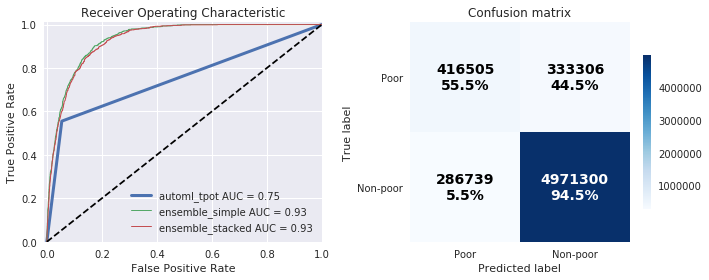

,automl_tpot,ensemble_simple,ensemble_stacked
accuracy,0.896794,0.845008,0.827208
recall,0.555481,0.873189,0.886484
precision,0.592262,0.418192,0.390749
f1,0.573282,0.565535,0.542411
cross_entropy,0.625172,0.34436,0.352263
roc_auc,0.750474,0.93394,0.929823
cohen_kappa,0.472997,0.464792,0.44074


Actual poverty rate: 11.38% 
Predicted poverty rate: 11.65% 


In [12]:
metrics = evaluation.evaluate_model(y_test,
                                    y_pred, 
                                    y_prob,
                                    w_test,
                                    compare_models=['ensemble_simple', 'ensemble_stacked'],
                                    prefix=ALGORITHM_NAME,
                                    model_name='tpot', 
                                    country=COUNTRY,
                                    predict_pov_rate=True,
                                    store_model=True,
                                    show=True,
                                    model=model)

The TPOT model appears to perform well in many metrics, but its ROC area and cross entropy are particularly bad. Recall that the ROC curve calculation is a function of the

1. predicted class probabilites
2. the threshold used to map the probabilties to classes

The axes, "true positive rate" and "false positive rate" depend on the threshold used to round the probabilties. The piecewise constant appearance of the ROC curve above sugggests that varying this threshold has little impact on the rounded classes. That implies that the class probabilities are likely clustered around just a few values. In other words, the model's confidence is consistent, and likely close to 50%.

We can check this claim by inspecting the class probabilities `y_prob`. First, convert the probabilities to a Pandas Series for easier manipulation.

In [13]:
y_prob_series = pd.Series(y_prob)

In [14]:
y_prob_series.describe()

count    1771.000000
mean        0.460739
std         0.020079
min         0.454262
25%         0.454262
50%         0.454262
75%         0.454262
max         0.522949
dtype: float64

Indeed, it appears the the class probabilities cluster very tightly from about 0.45 to just over 0.5, with a relatively small standard deviation.

Check the number of unique predicted probabilties

In [15]:
y_prob_series.nunique()

2

Just 3 values! The model isn't very confident at all. We can see a histogram of those predictions here:

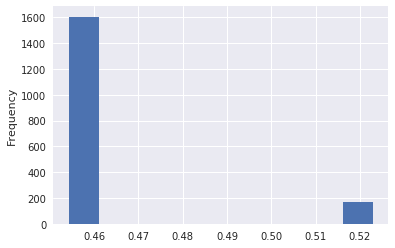

In [16]:
y_prob_series.plot.hist()

It looks like optimization with respect to f1 led the model to only predict very specific probabilities. While we can't be sure why this is the case, it is possible that the genetic algorithm is getting stuck in a local minimum during optimization.

# Summary <a class="anchor" id="summary"></a>

The TPOT package is certainly easy to use, and it produced OK results against some metrics given the very little effort required to train the model. However, the oprtimization process not only led to a strange, hard-to-interpret pipeline, but also a very biased classifier that only predicts 3 unique values. It is possible that other TPOT configurations could help improve the metrics. The purpose of this exercise was to see how AutoML performs "out of the box," and it seems that given the comnputational power needed to obtain these results, we are perhaps better off relying on simpler models.